In [276]:
import torch
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from math import pi

# 1.创建测试数据
1. 定义 3 个二元高斯分布
2. 从这 3 个高斯分布中分别产生  100+200+300=600 个数据点
3. 作图展示这 600 个数据点

## 1.1 定义 3 个二元高斯分布

In [194]:
# 定义每个高斯分布的平均数组成的 3*2 矩阵
mean_matrix = torch.Tensor([
    [1.2, 0.4],
    [-4.4, 1.0],
    [4.1, -0.3]
])

# 定义每个高斯分布的协方差矩阵
covariance_matrix = torch.zeros([3,2,2])
covariance_matrix[0] = torch.Tensor([[0.8, -0.4], [-0.4, 1.0]])
covariance_matrix[1] = torch.Tensor([[1.2, -0.8], [-0.8, 1.0]])
covariance_matrix[2] = torch.Tensor([[1.2, 0.6], [0.6, 3.0]])

In [195]:
gaussians = [MultivariateNormal(mean, covariance) for mean,covariance in zip(mean_matrix, covariance_matrix)]

## 1.2 创建测试数据

In [12]:
def generate_samples(n_samples=[100,200,300]):
    samples = torch.Tensor()
    for i in range(3):
        gaussian = gaussians[i]
        samples = torch.cat((samples, gaussian.rsample([n_samples[i]])))
    return samples

In [13]:
samples = generate_samples()

## 1.3 绘图

In [14]:
df = pd.DataFrame(samples.numpy(), columns=['X', 'Y'])
df['Gaussian'] = 0
df.loc[100:300,'Gaussian'] = 1
df.loc[300:600,'Gaussian'] = 2

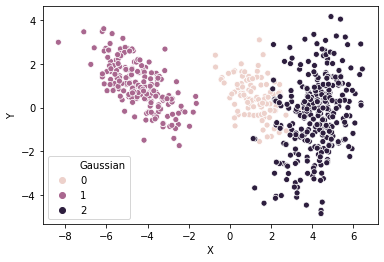

In [15]:
sns.scatterplot(x='X', y='Y', hue='Gaussian', data=df)

# GMM

使用 EM 算法来估算 GMM 的参数。

测试数据的 shape 为 `[600, 2]`

1. e-step: 计算 $P(z_k=1|x)$。得到的是 shape 为 `[3, 600]`
2. m-step: 计算 
* new mean，尺寸为 `[3,2]`
* new covariance，尺寸为 `[3,2,2]`
* new mixing coefficients，尺寸为 `[3,1]`

In [277]:
class GMM:
    def __init__(self):
        self.num_gaussians = None
        self.means, self.covs, self.mixing_coefs = [None] * 3

    def initialize(self, num_gauss, num_dimens):
        """EM 算法可以使用 k-means 来做参数初始化；此处为了方便，采用随机初始化"""
        mean_matrix = torch.rand([num_gauss, num_dimens])  # 3*2
        covariance_matrix = torch.stack([self._cov(torch.rand([num_dimens, 10])) for i in range(num_gauss)])
        mixing_coefs = torch.Tensor([1 / num_gauss] * num_gauss)
        return mean_matrix, covariance_matrix, mixing_coefs

    def fit(self, data, num_gaussians=3, max_iter=500):
        self.num_gaussians = num_gaussians
        self.means, self.covs, self.mixing_coefs = self.initialize(num_gaussians, data.shape[1])
        log_likelihoods = []
        for i in range(max_iter):
            log_likelihoods.append(self.log_likelihood(data, self.means, self.covs, self.mixing_coefs))
            print(i, log_likelihoods[-1])
            responsibilities = self.e_step(data, self.means, self.covs, self.mixing_coefs)
            self.means, self.covs, self.mixing_coefs = self.m_step(data, responsibilities)

    def e_step(self, data, means, covs, mixing_coefs):
        responsibilities = [None] * len(mixing_coefs)
        for i in range(len(mixing_coefs)):
            responsibilities[i] = (self._cal_prob(means[i], covs[i], data=data).T * mixing_coefs[i]).squeeze()
        responsibilities = torch.stack(responsibilities)
        responsibilities = self._normalize(responsibilities)
        return responsibilities

    def m_step(self, data, responsibilities):
        n_k = responsibilities.sum(1).view(self.num_gaussians, 1)  # n_k 为 3*1
        new_mean = 1 / n_k * torch.mm(responsibilities, data)  # 3*2

        # 如下操作有点复杂。实际上不需要 for 循环最后再 stack，但是这样相对比较好理解
        new_cov = [None] * self.num_gaussians
        for i in range(self.num_gaussians):
            data_minus_mean = (data - new_mean[i]).view((data.shape[0], data.shape[1], -1))  # 600*2*1
            responsibility = torch.unsqueeze(responsibilities[i], 0).T.view((data.shape[0], 1, 1))  # 600*1*1
            new_cov[i] = torch.bmm(data_minus_mean, data_minus_mean.transpose(1, 2))  # 600*2*2
            new_cov[i] = (new_cov[i] * responsibility).sum(dim=0)  # 2*2
            new_cov[i] = new_cov[i] / n_k[i].item()
        new_cov = torch.stack(new_cov)  # 3*2*2

        new_mixing_coefficients = n_k / self.num_gaussians  # 3*1

        return new_mean, new_cov, new_mixing_coefficients

    def log_likelihood(self, data, means, covs, mixing_coefs):
        likelihood = torch.zeros([data.shape[0], 1])  # 600*1
        for i in range(len(mixing_coefs)):
            l = self._cal_prob(means[i].view([-1, data.shape[1]]), covs[i].view([-1, data.shape[1]]), data=data)
            likelihood += l * mixing_coefs[i].item()
        log_likelihood = likelihood.log()
        log_likelihood = torch.clamp(log_likelihood, 1e-6)
        log_likelihood = torch.sum(log_likelihood)
        return log_likelihood

    def _cov(self, m):
        m_exp = torch.mean(m, dim=1)
        x = m - m_exp[:, None]
        cov = 1 / (x.size(1) - 1) * x.mm(x.t())
        return cov

    def _cal_prob(self, mean, cov, data):
        """给定一个高斯分布，以及一批数据，计算每一条数据来自这个高斯分布的概率"""
        # data : 600*1*2; mean: 1*2; cov: 2*2
        data = data.view([data.shape[0], 1, data.shape[1]])
        data_minus_mean = data - mean  # 600*1*2
        denominator = (-0.5*torch.bmm(data_minus_mean @ cov.inverse(), data_minus_mean.transpose(1,2))).exp()
        numerator = ((2 * pi) ** (data.shape[0] / 2)) * torch.sqrt(torch.det(cov)).item()
        return denominator.view([data.shape[0], 1]) / numerator

    def _normalize(self, data):
        """给定 M*N 的数据 data，对行求和，然后 data 中每个元素除以所在行的和"""
        axis_sums = data.sum(1)
        axis_sums = axis_sums.view([axis_sums.shape[0], 1])
        return data / axis_sums

In [278]:
g = GMM()
g.fit(samples)

0 tensor(0.0006)
1 tensor(nan)
2 tensor(nan)
3 tensor(nan)
4 tensor(nan)
5 tensor(nan)
6 tensor(nan)
7 tensor(nan)
8 tensor(nan)
9 tensor(nan)
10 tensor(nan)
11 tensor(nan)
12 tensor(nan)
13 tensor(nan)
14 tensor(nan)
15 tensor(nan)
16 tensor(nan)
17 tensor(nan)
18 tensor(nan)
19 tensor(nan)
20 tensor(nan)
21 tensor(nan)
22 tensor(nan)
23 tensor(nan)
24 tensor(nan)
25 tensor(nan)
26 tensor(nan)
27 tensor(nan)
28 tensor(nan)
29 tensor(nan)
30 tensor(nan)
31 tensor(nan)
32 tensor(nan)
33 tensor(nan)
34 tensor(nan)
35 tensor(nan)
36 tensor(nan)
37 tensor(nan)
38 tensor(nan)
39 tensor(nan)
40 tensor(nan)
41 tensor(nan)
42 tensor(nan)
43 tensor(nan)
44 tensor(nan)
45 tensor(nan)
46 tensor(nan)
47 tensor(nan)
48 tensor(nan)
49 tensor(nan)
50 tensor(nan)
51 tensor(nan)
52 tensor(nan)
53 tensor(nan)
54 tensor(nan)
55 tensor(nan)
56 tensor(nan)
57 tensor(nan)
58 tensor(nan)
59 tensor(nan)
60 tensor(nan)
61 tensor(nan)
62 tensor(nan)
63 tensor(nan)
64 tensor(nan)
65 tensor(nan)
66 tensor(nan)
67

In [273]:
a = torch.Tensor([[1,2]])
a.squeeze()


tensor([1., 2.])

In [271]:
print(((a-b) @ torch.Tensor([[1,2],
                 [3,4]])).shape)
torch.bmm((a-b) @ torch.Tensor([[1,2],
                 [3,4]]),  a.transpose(1,2))

torch.Size([3, 1, 2])


tensor([[[ -96.]],

        [[-144.]],

        [[-112.]]])

In [19]:
model = GaussianMixture(n_components=3, max_iter=500)

model.fit(samples.numpy())

print(model.weights_,'\n')
print(model.means_,'\n')
print(model.covariances_)

[0.47342993 0.33311062 0.19345945] 

[[ 4.27643536 -0.36384238]
 [-4.39228503  1.04001632]
 [ 1.38122375  0.4445219 ]] 

[[[ 0.87613916  0.58941286]
  [ 0.58941286  3.0261739 ]]

 [[ 1.23536589 -0.7767713 ]
  [-0.7767713   1.07274224]]

 [[ 0.82985109 -0.2942447 ]
  [-0.2942447   0.89986558]]]
